In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [19]:
p_true = 0.05
N = 1500
occurrences = stats.bernoulli.rvs(p_true, size=N)
print(occurrences)
print(np.sum(occurrences))

[0 0 1 ..., 0 0 0]
78


In [20]:
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0520
Does this equal the true frequency? False


In [30]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(1800*10, step=step)
    burned_trace = trace[1000:]

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 18000/18000 [00:01<00:00, 9239.17it/s]


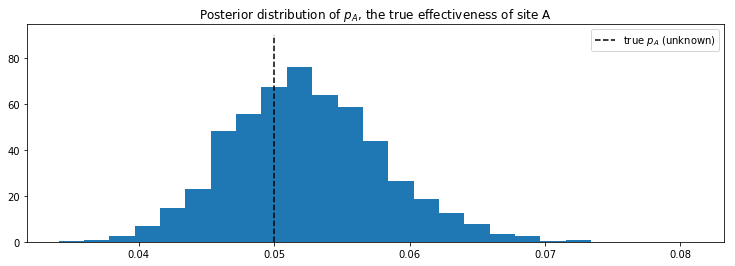

In [31]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

# AB test

In [39]:
import pymc3 as pm
plt.figure(figsize=(12,4))

true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 750

observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] ...


In [40]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.0533333333333
0.0386666666667


In [42]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    delta = pm.Deterministic('delta', p_A - p_B)
    obs_A = pm.Bernoulli('obs_A', p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=observations_B)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 20000/20000 [00:04<00:00, 4502.97it/s]


In [43]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

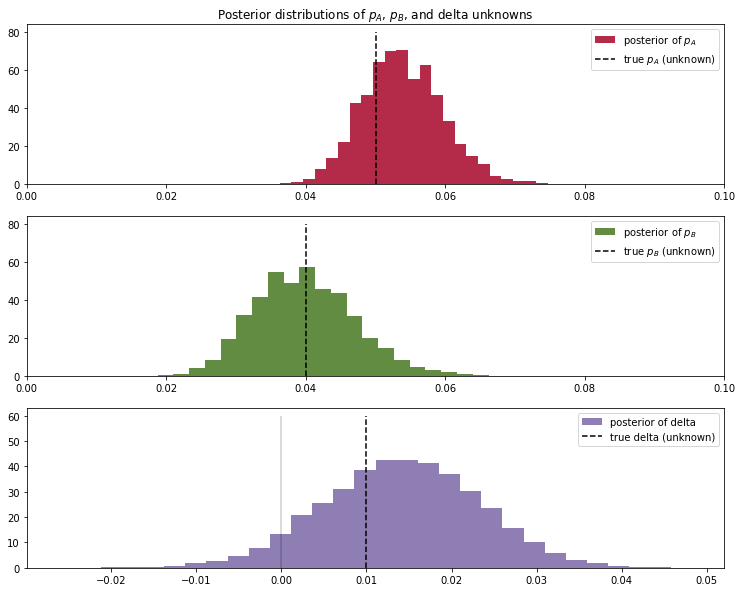

In [44]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [45]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.062
Probability site A is BETTER than site B: 0.938


# Binomial Distibution

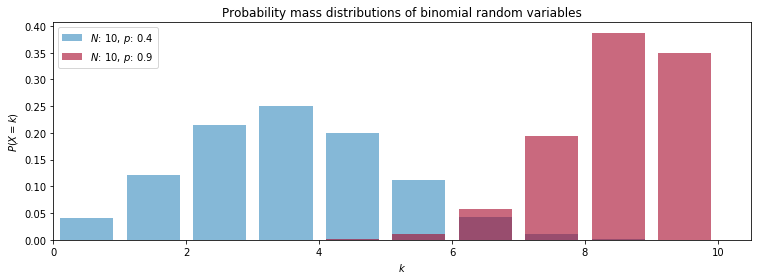

In [49]:
plt.figure(figsize=(12.5,4))
binomial = stats.binom

parameters = [(10,0.4), (10,.9)]
colors= ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N+1)
    plt.bar(_x -0.5, binomial.pmf(_x, N, p), color=colors[i], alpha=0.6, linewidth=3, 
           label="$N$: %d, $p$: %.1f" % (N, p))

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

# Cheating Survey

In [50]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

In [51]:
with model:
    true_answers = pm.Bernoulli('thuths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [52]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)    

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


[1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0
 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0]


In [53]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [54]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [55]:
observed_proportion.tag.test_value

array(0.4699999988079071)

In [56]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

/opt/conda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [57]:
# To be explained in Chapter 3!
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Assigned BinaryGibbsMetropolis to thuths
Assigned BinaryGibbsMetropolis to first_flips
Assigned BinaryGibbsMetropolis to second_flips
100%|██████████| 40000/40000 [15:14<00:00, 43.72it/s]


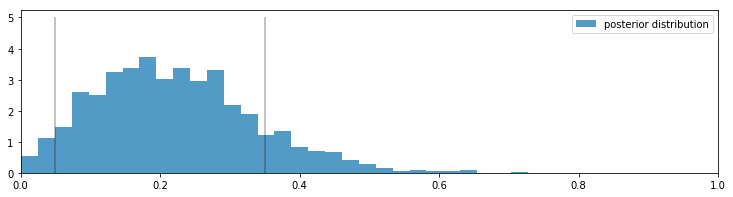

In [58]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

# Example: Challenger Space Shuttle Disaster

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


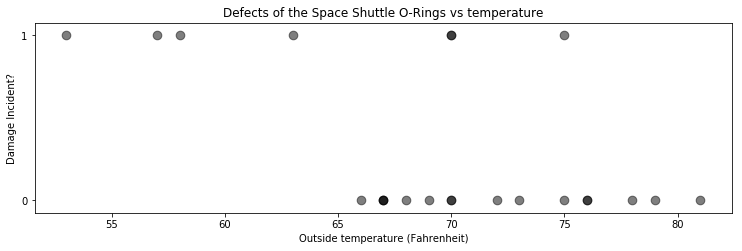

In [59]:
plt.figure(figsize=(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

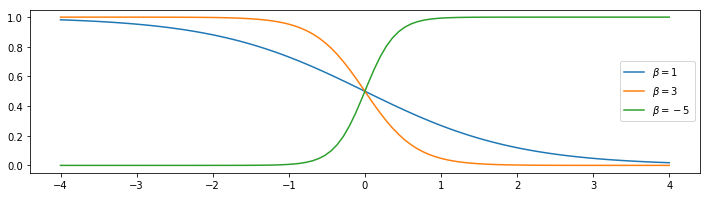

In [60]:
plt.figure(figsize=(12,3))

def logistic(x, beta):
    return 1.0 / (1.0+np.exp(beta*x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();